In [1]:
from whobpyt.datatypes import par
from whobpyt.models.RWW import RNNRWW, ParamsRWW
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting
from sklearn.model_selection import train_test_split

# # array and pd stuff
import numpy as np
import torch
from scipy.io import loadmat # for reading in the .mat files

# viz stuff
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_avg_fc(fcs):
    corr_matrices = []

    for data in fcs:
        fc = np.corrcoef(data.T)
        corr_matrices.append(fc)

    stacked_corr = np.stack(corr_matrices, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [3]:
def get_avg_fmr(fmris):
    stacked_corr = np.stack(fmris, axis = 0)
    avg_corr = np.mean(stacked_corr, axis =0)
    
    return avg_corr

In [4]:
sc = np.genfromtxt('../data/DTI_fiber_consensus_HCP.csv', delimiter=',')

with open('../data/healthy_subjs.txt', 'r') as file:
    fc_files = file.readlines()

fc_files = [file.strip() for file in fc_files]

fcs = []

for file in fc_files:
    fc = loadmat(f'../{file}')
    fc = fc['ROI_activity'][:100, :]   # get first 100 regions: Schaefer
    if fc.shape[1] == 197:            # get all scans that are 197 long
        fc = fc.T
        fcs.append(fc)

print(fcs[0].shape)

# normalise all fcs - zscore
for i, fc in enumerate(fcs):
    fcs[i] = (fc - fc.mean(axis=0)) / fc.std(axis=0)   # want to calculate along the time axis

train_data, test_data = train_test_split(fcs, test_size=0.2, random_state=42)

print('Training set: ', len(train_data))
print('Test set: ', len(test_data))

FileNotFoundError: [Errno 2] No such file or directory: '../../FMRI_ADNI_DATA/fc/sub-ADNI011S0021_ses-M144_task-rest_space-MNI152Lin_res-2_desc-preproc_bold_ExtSchaefer116_ROI_activity.mat'

In [ ]:
tr = 0.75

SC = (sc + sc.T) * 0.5
sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))

fc_emp_train = get_avg_fc(train_data)
fc_emp_test = get_avg_fc(test_data)

(197, 100)


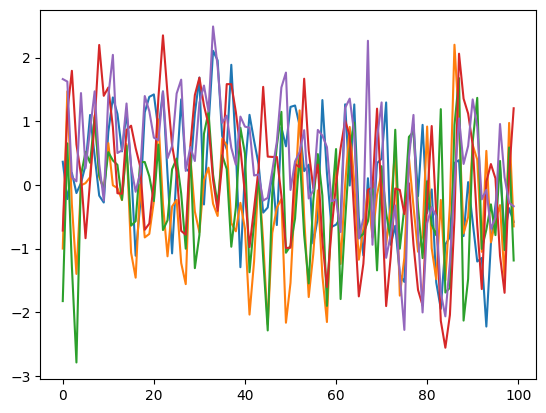

In [ ]:
plt.plot(fcs[0][:100, :5])
print(fcs[0].shape)

In [ ]:
# %%
# define options for wong-wang model
node_size = 100
mask = np.tril_indices(node_size, -1)
num_epochs = 50
TPperWindow = 20
step_size = 0.1
input_size = 2
tr = 0.75
repeat_size = 5
ts_length = fcs[0].shape[0]

#  {'learning_rate': 0.1, 'num_epochs': 100, 'step_size': 0.1, 'G': 500}

In [ ]:
# %%
# get model parameters structure and define the fitted parameters by setting non-zero variance for the model
# params = ParamsRWW(g=par(400, 400, 1/np.sqrt(10), True, True), g_EE=par(1.5, 1.5, 1/np.sqrt(50), True, True), g_EI =par(0.8, 0.8, 1/np.sqrt(50), True, True), \
#                    g_IE=par(0.6, 0.6, 1/np.sqrt(50), True, True), I_0 =par(0.2), std_in=par(0.0), std_out=par(0.00))

# remember that the g originally was 100 here
params = ParamsRWW(g=par(1000, 1000, 1/np.sqrt(10), True, True), g_EE=par(3.5, 3.5, 1/np.sqrt(50)), g_EI =par(0.42, 0.42, 1/np.sqrt(50)), \
                   g_IE=par(0.42, 0.42, 1/np.sqrt(50)), I_0 =par(0.2), std_in=par(0.0), std_out=par(0.00))

# params = ParamsRWW(g=par(82, 82, 1/np.sqrt(10), True, True), g_EE=par(2.49, 2.49, 1/np.sqrt(50), True, True), g_EI =par(0.501, 0.501, 1/np.sqrt(50), True, True), \
#                    g_IE=par(0.4774, 0.4774, 1/np.sqrt(50), True, True), I_0 =par(0.2), std_in=par(0.0), std_out=par(0.00))
# %%
# call model want to fit
model = RNNRWW(node_size, TPperWindow, step_size, repeat_size, tr, sc, True, params)

# %%
# create objective function
ObjFun = CostsRWW(model)

# %%
# call model fit
F = Model_fitting(model, ObjFun)

In [ ]:
# Model Training
# ---------------------------------------------------
#
# F.train(u = 0, empRecs = rcds, num_epochs = num_epochs, TPperWindow = TPperWindow, learningrate = 0.05)

# F.train(u = 0, empRecs = [data_mean], num_epochs = num_epochs, TPperWindow = TPperWindow, learningrate = 0.05)

F.train(u = 0, empFcs = [torch.from_numpy(fc_emp_train)], num_epochs = num_epochs, num_windows = int(ts_length / TPperWindow), learningrate = 0.1)

Epoch:  0
epoch:  0 loss: 10.111665175208843 Pseudo FC_cor:  0.26213860769493025
Epoch:  1
epoch:  1 loss: 7.445353846297499 Pseudo FC_cor:  0.20691342730372003
Epoch:  2
epoch:  2 loss: 7.210046804192594 Pseudo FC_cor:  0.20955322500997434
Epoch:  3
epoch:  3 loss: 7.426168166855776 Pseudo FC_cor:  0.22897835434328026
Epoch:  4
epoch:  4 loss: 7.859792456343866 Pseudo FC_cor:  0.2034793572994925
Epoch:  5
epoch:  5 loss: 6.913651589928529 Pseudo FC_cor:  0.3527182217557279
Epoch:  6
epoch:  6 loss: 6.666263545125033 Pseudo FC_cor:  0.3004267295737149
Epoch:  7
epoch:  7 loss: 7.0441180691085625 Pseudo FC_cor:  0.3657551089504387
Epoch:  8
epoch:  8 loss: 6.480058347685685 Pseudo FC_cor:  0.3013530812729988
Epoch:  9
epoch:  9 loss: 7.159077705170054 Pseudo FC_cor:  0.2943631112888942
Epoch:  10
epoch:  10 loss: 6.487982601730344 Pseudo FC_cor:  0.34264716957955943
Epoch:  11
epoch:  11 loss: 6.33970333879849 Pseudo FC_cor:  0.3268864821811202
Epoch:  12
epoch:  12 loss: 6.177273714488

Text(0, 0.5, 'Loss')

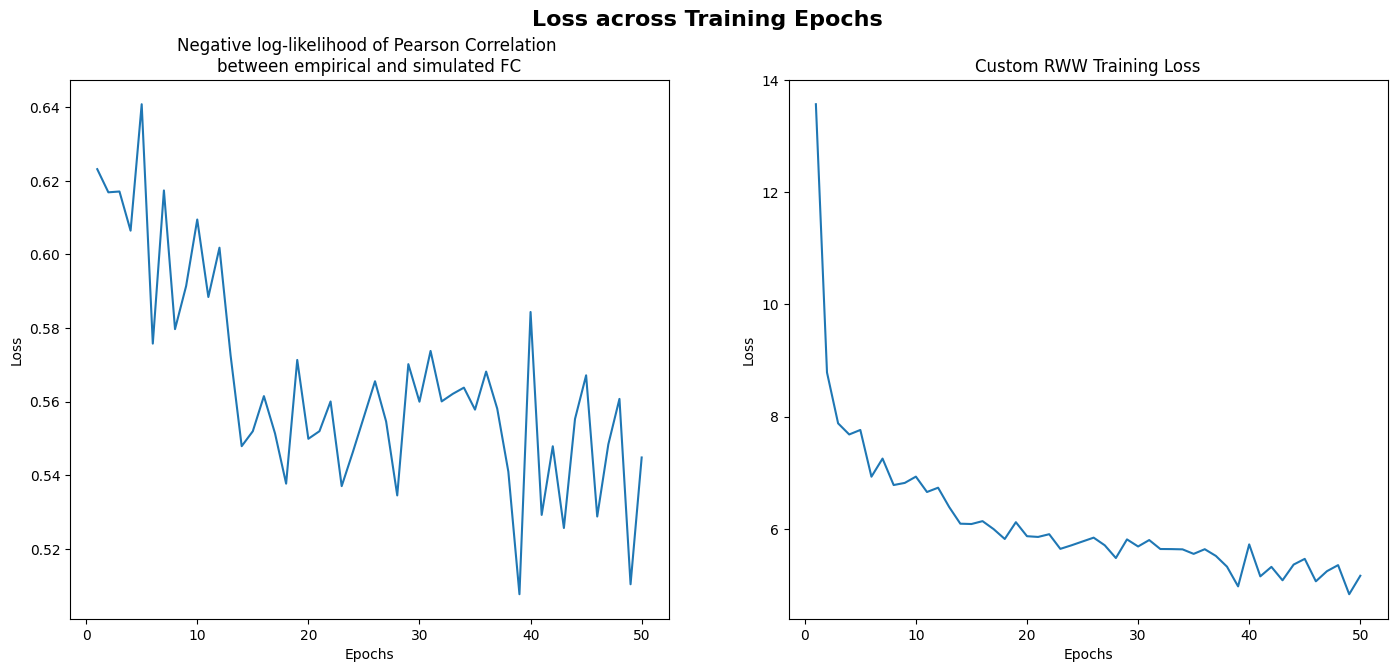

In [ ]:
# Plots of loss over Training
# plt.plot(np.arange(1,len(F.trainingStats.loss)+1), F.trainingStats.loss, label='loss')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))
plt.suptitle('Loss across Training Epochs', fontsize=16, fontweight='bold')

ax1.plot(np.arange(1,len(F.trainingStats.loss)+1), F.trainingStats.main_loss, label='main_loss')
ax1.set_title("Negative log-likelihood of Pearson Correlation \nbetween empirical and simulated FC")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.arange(1,len(F.trainingStats.loss)+1), F.trainingStats.loss, label='main_loss')
ax2.set_title("Custom RWW Training Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

# # %%
# # Plots of parameters values over Training
# plt.plot(F.trainingStats.fit_params['g'], label = "G")
# plt.legend()
# plt.title("Global Coupling Variable Changing Over Training Epochs")
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

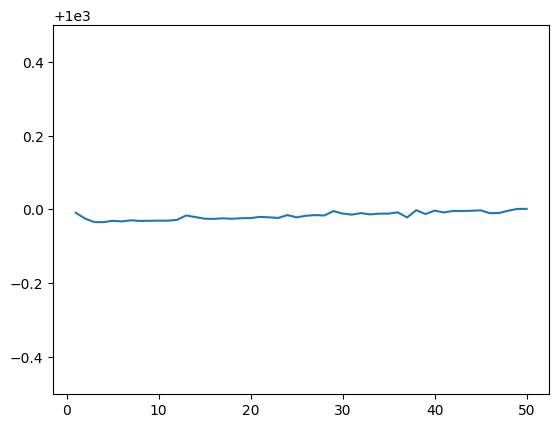

In [ ]:
g_arr = np.asarray([x.item() for x in F.trainingStats.fit_params['g']])

plt.plot(np.arange(1, 51),  g_arr)
plt.ylim(999.5, 1000.5)
plt.show

In [ ]:
min(g_arr)

999.9656372070312

Pearson Correlations:  0.38162547869766184


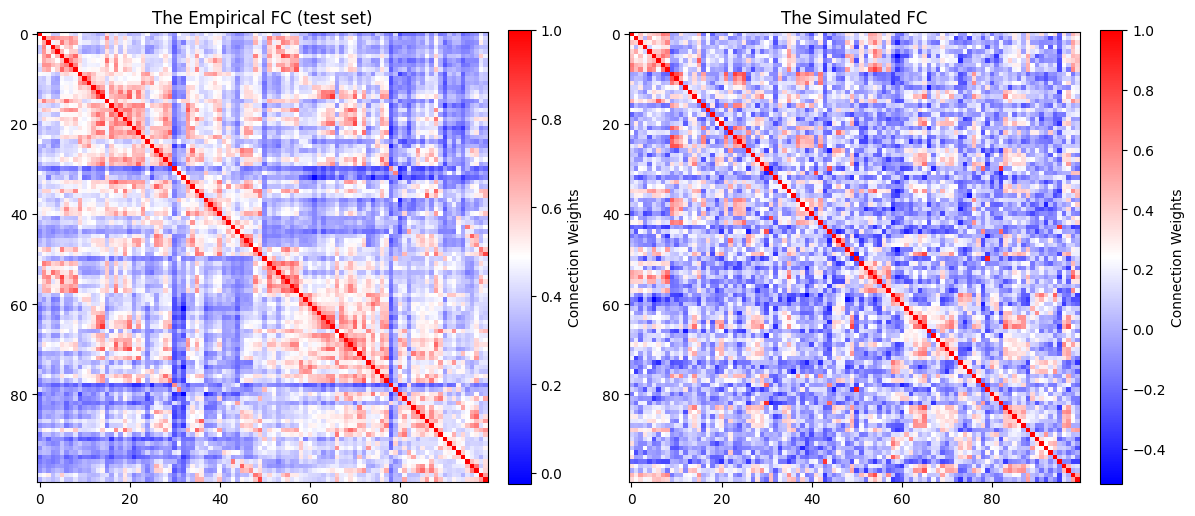

In [ ]:
# Model Evaluation (with 20 window for warmup)
# ---------------------------------------------------
# old_sim = 0

# while old_sim < 0.48:

# Simulate the functional connectivity:
ts_sim, fc_sim = F.simulate(u =0, num_windows=int(ts_length/TPperWindow), base_window_num=20)

# average the evaluation scores across empirical data
fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])

old_sim = fc_cor

# -----------------------------------------------------------
# Plot the simulated FC + BOLD time series:

# Plot the FC and the test FC
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
im0 = ax[0].imshow(fc_emp_test, cmap='bwr')
ax[0].set_title('The Empirical FC (test set)')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')

im1 = ax[1].imshow(fc_sim, cmap='bwr')
ax[1].set_title('The Simulated FC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

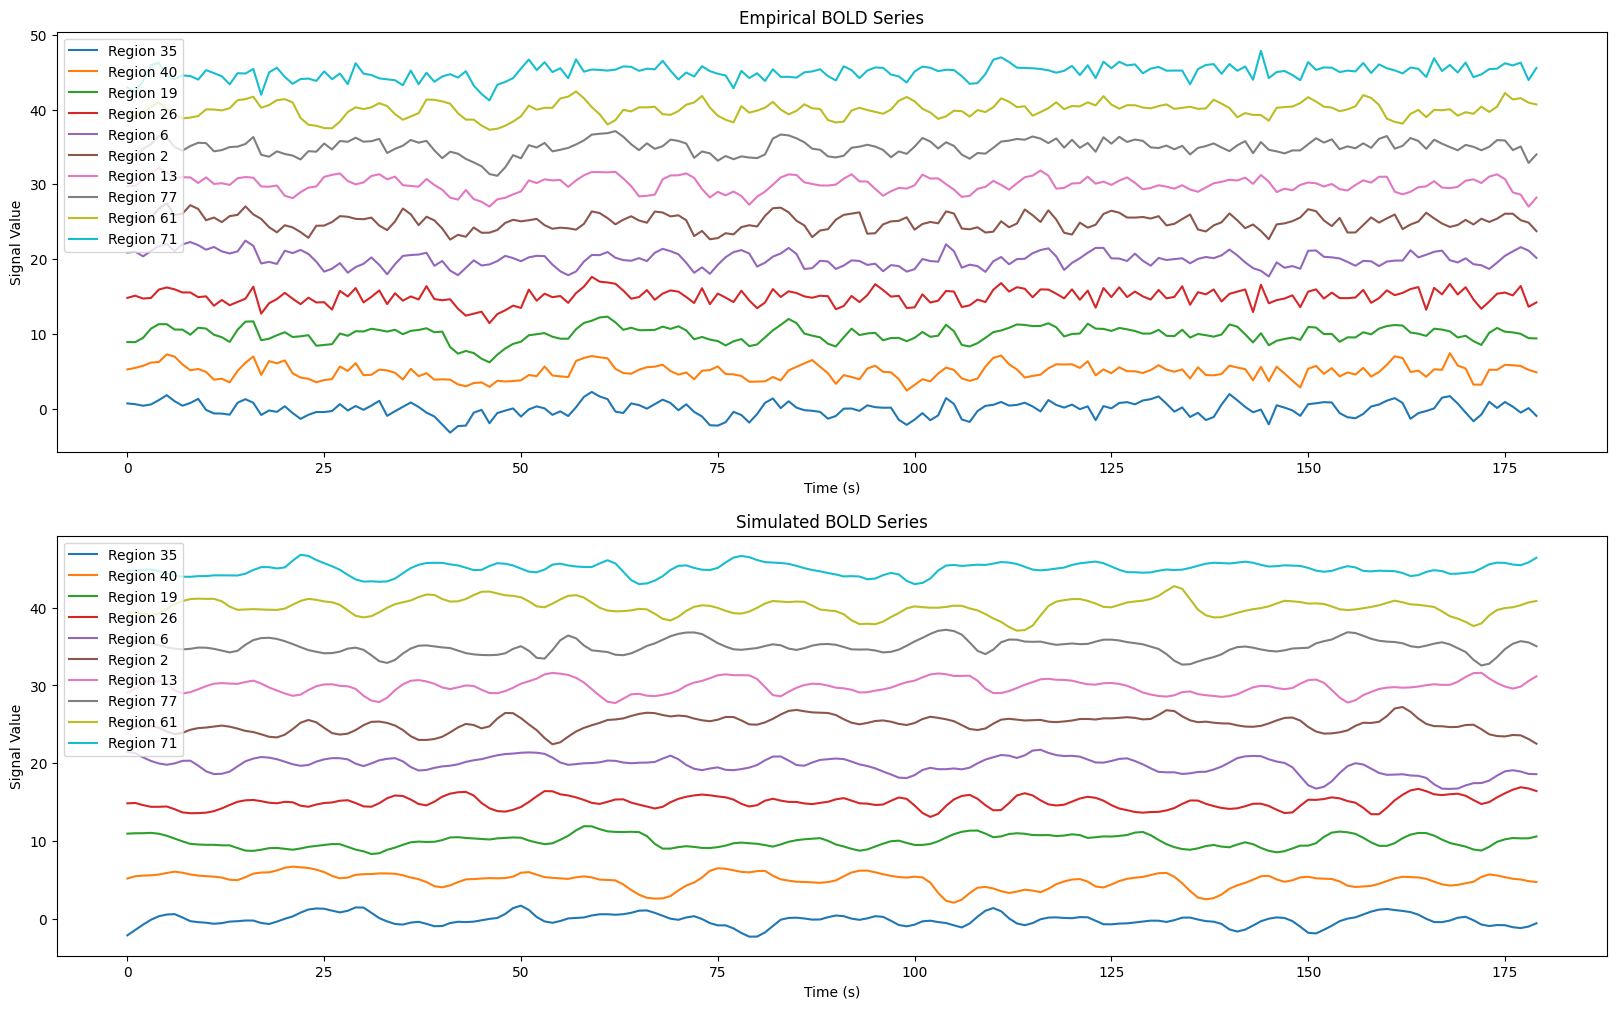

In [ ]:
# Plot E I and simulated BOLD - separate lines for regions
emp_bold = test_data[1][:180].T
sim_bold = ts_sim
# Standardise times series
sim_bold = (sim_bold - sim_bold.mean(axis=0)) / sim_bold.std(axis=0)

# Select 10 unique random column indices
region_indices = np.random.choice(emp_bold.shape[0], 10, replace=False)
# # Select the columns using the random indices
subset_emp = emp_bold[region_indices, :]
subset_sim = sim_bold[region_indices, :]

k = 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

for idx, sub_array in enumerate(subset_emp):
    ax1.plot(sub_array + k, label=f'Region {region_indices[idx]}')
    k += 5

ax1.legend(loc='upper left')

# Add labels and title
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal Value')
ax1.set_title('Empirical BOLD Series')
# plt.show()

k = 0

for idx, sub_array in enumerate(subset_sim):
    ax2.plot(sub_array + k, label=f'Region {region_indices[idx]}')
    k += 5

# Add a legend to differentiate the plots
ax2.legend(loc='upper left')

# Add labels and title
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Signal Value')
ax2.set_title('Simulated BOLD Series')

plt.show()

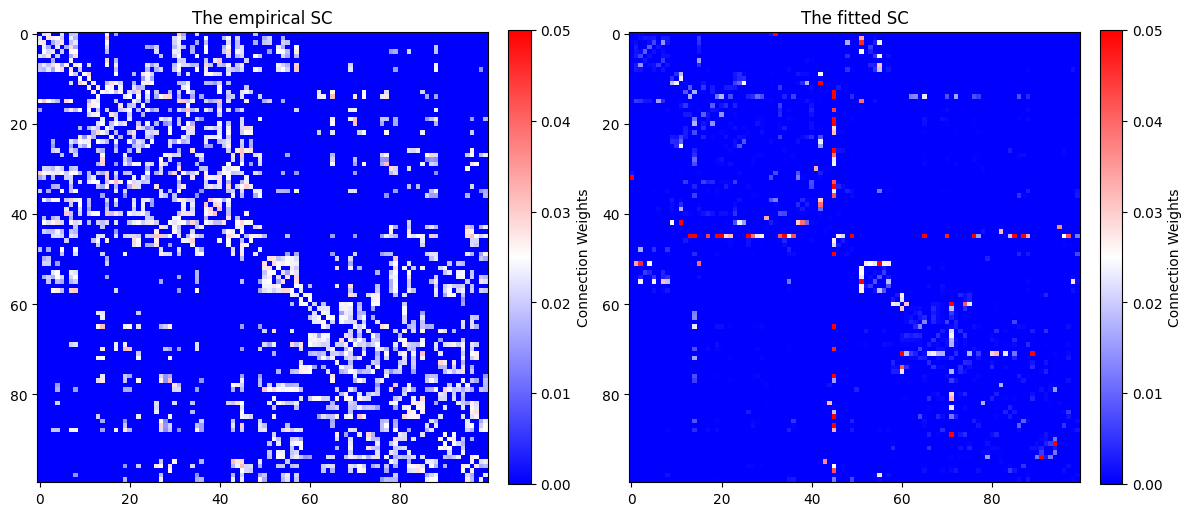

In [ ]:
# Plot SC and fitted SC

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
im0 = ax[0].imshow(sc, cmap='bwr', vmin = 0.0, vmax = 0.05)
ax[0].set_title('The empirical SC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04, label='Connection Weights')
im1 = ax[1].imshow(F.model.sc_fitted.detach().numpy(), cmap='bwr', vmin = 0.0, vmax = 0.05)
ax[1].set_title('The fitted SC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

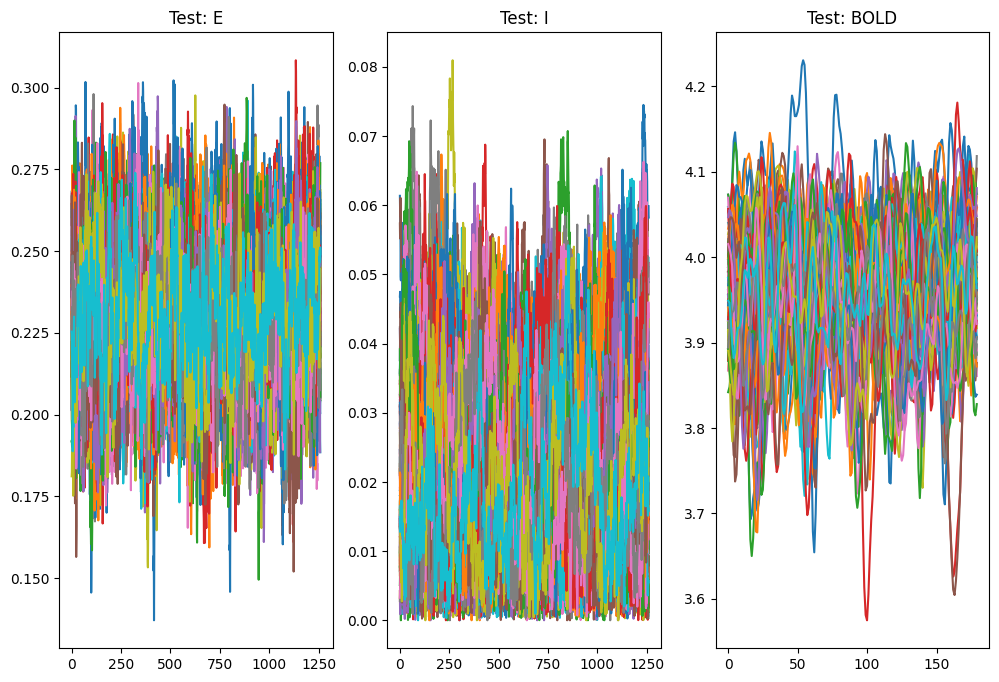

In [ ]:
# Plot E I and simulated BOLD
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(F.lastRec['E'].npTS().T)
ax[0].set_title('Test: E')
ax[1].plot(F.lastRec['I'].npTS().T)
ax[1].set_title('Test: I')
ax[2].plot(F.lastRec['bold'].npTS().T)
ax[2].set_title('Test: BOLD')
plt.show()

### Plot the Empirical FC against Simulated FC 
Plot the lower triangles of each matrix against each other to replicate one of the plots from Griffith's paper

Text(0.5, 1.0, 'Regional Predictions for Functional Connectivity (FC)')

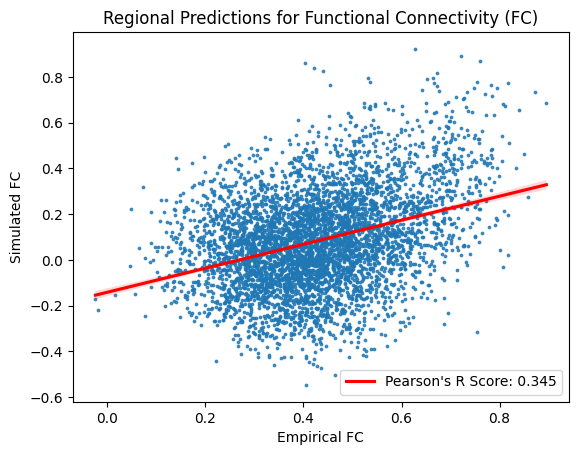

In [ ]:
# Get the lower triangle

mask_e = np.tril_indices(node_size, -1)

lower_triangle_emp = fc_emp_test[mask_e]
lower_triangle_sim = fc_sim[mask_e]

ax = sns.regplot(x=lower_triangle_emp, y=lower_triangle_sim, line_kws={'color':'red', 'label':f"Pearson's R Score: {fc_cor:.3f}"}, scatter_kws={'s':3})
ax.legend(loc='lower right')
# plt.legend(labels=['areger'])
plt.xlabel('Empirical FC')  # Replace 'X Axis Label' with the label for your x-axis
plt.ylabel('Simulated FC')  # Replace 'Y Axis Label' with the label for your y-axis
plt.title('Regional Predictions for Functional Connectivity (FC)')   # Replace 'Scatter Plot' with the title for your plot

# plt.savefig('ventricular_gbm_regressor_hyperparam_tuned.png')

## Getting Prediction Statistics
Calculate average corr score and standard deviation

In [ ]:
# iterations = 20
# corrs = np.zeros(20)

# for i in range(iterations):
#     _, fc_sim = F.simulate(u =0, num_windows=int(ts_length/TPperWindow), base_window_num=20)

#     # average the evaluation scores across empirical data
#     fc_cor = F.evaluate(empFcs=[fc_emp_test], fc_sims=[fc_sim])
#     corrs[i] = fc_cor

# print('=================================================')
# print('Mean FC Corr Score: ', np.mean(corrs))
# print('Standard Dev for FC Corr Score: ', np.std(corrs))

## Saving + Loading Models

In [ ]:
# F.save('models/healthy_rww_model.pkl')

In [ ]:
# import pickle

# # Load the model from the file
# with open('50epoch_lr01_step01_g100.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
# model.evaluate(u = 0, empRecs = [data_mean], TPperWindow = TPperWindow, base_window_num = 20)